
# Comments on what this notebook does:

WARNING:

For the script to work the data files must be positiong in the data path of the repository. 
Or the path to the data must be adapted accordingly. In this script all csv data must be in data_path 

# The data which is used here has received the following steps already 

* mapping of entries in countrys, and companies and so on, see Andreas jupyter notebooks 
* only unique values remains in columns which are categorical 

# The process steps which will be done in here:**

 * Retrieving data
 + Get an overview and count empty entries in the dataset  
 + Drop Fuel consumption because it is too much correlated with CO2 Emission 
 * Explanatory Variable is Ewltp (g/km) and Erwltp(g/km)
 + Filter all data that has no explanatory variable  
 + Drop data before 2015 because of VW diesel Scandal 
 + Drop data before 2018 because of the succesfull implementation of the new WLT measurement (which will be our target variable Ewltp)
 + Keep all contries, discuss why 
 + Search for unique Car Identification number to ommit double cars which have the same characterisics 
 + Discuss percentage error compared to the mean value for different car IDs: TAN, VFN, Ves
 + Filter out Ve that are not combination from T & Va = Ve 
 + Filter out rows which have ? in their Ve 

 + Drop Columns which are not relevant: ID, r
 + make separate DF with electric cars for separate research

 + Save DF to csv 
 

 

# Import Libraries

In [1]:
# First of all import the required libraries 
# Data and math  
import pandas as pd
import numpy as np 
import pyarrow.parquet as pq

# Visualisation 
import matplotlib.pyplot as plt  # für Matplotlib
import seaborn as sns            # für Seaborn
import plotly.express as px      # für Plotly Express
#%matplotlib inline

# Import System Libraries 
import warnings
import os
# Ignor all warnings, because there is a front problem with mach 
warnings.filterwarnings("ignore")


## Retrieving Data, deleting empty entries, Save dfs in callable variables

In [33]:
# Loading data 

# Path to the neighboring 'data' folder
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data'))

# Check the path
print(data_path + '/EU_all_current_shared.parquet')

# Load parquet data
table = pq.read_table(os.path.join(data_path, 'EU_all_current_shared.parquet'))

# Convert to pandas DataFrame
df = table.to_pandas()

# Show the first few rows to confirm
print(df.head())

/Users/tillo/Repositoriums/aug24_bds_int---co2/data/EU_all_current_shared.parquet
         ID Country  VFN              Mp              Mh  \
0  280060.0      UK  NaN             NaN         UNKNOWN   
1  280060.0      UK  NaN             NaN         AUDI AG   
2  280060.0      PL  NaN     VW GROUP PC      VOLKSWAGEN   
3  280060.0      HU  NaN             NaN  HYUNDAI ASSAN    
4  280060.0      HU  NaN  GENERAL MOTORS            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  e1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va  ...  De  Vf Status    year Date of registration  \
0  A-H/MONOCAB     BF11  ... NaN NaN      P  2010.0         

# Filter for missing values (coming from andreas notebook)

In [3]:
def count_missing_values(df):
    missing_counts = {}
    
    for col in df.columns:
        # Count pd.NA and np.nan separately
        pd_na_count = df[col].isna().sum() if df[col].dtype.name == 'category' else 0
        np_nan_count = df[col].isna().sum() if df[col].dtype.name == 'float32' else 0
        
        # Store the results
        missing_counts[col] = {'pd.NA': pd_na_count,
                               'np.nan': np_nan_count,
                               'Dtype': df[col].dtype.name,
                               'Percent Missing': f"{df[col].isna().sum() / len(df[col]) * 100:.2f}%"
                              }

    # Convert the results to a DataFrame for easier viewing
    result_df = pd.DataFrame(missing_counts).T
    return result_df

# Count and display the missing values
result = count_missing_values(df)
print(result)

                          pd.NA    np.nan     Dtype Percent Missing
ID                            0         0   float32           0.00%
Country                       0         0  category           0.00%
VFN                     6022343         0  category          41.70%
Mp                      1538457         0  category          10.65%
Mh                            0         0  category           0.00%
Man                      310768         0  category           2.15%
MMS                     6048284         0  category          41.88%
Tan                      490543         0  category           3.40%
T                         62037         0  category           0.43%
Va                       100484         0  category           0.70%
Ve                       225223         0  category           1.56%
Mk                        42908         0  category           0.30%
Cn                        49370         0  category           0.34%
Ct                        24710         0  categ

# Drop fuel consumption 

In [46]:
# Create a new DataFrame containing only fuel type and fuel consumption
df_withfuel = df
df_fuel = df_withfuel[['Ft', 'Fuel consumption ','Ewltp (g/km)']]
# Create a new DataFrame without the "Fuel consumption" column 
# because it is to much correlated with the target variable 
df_new = df.drop(columns=['Fuel consumption '])

# Drop all data that does not contain target variable Ewltp (g/km)

In [6]:
# Delete all rows which have no informat on the target variable 
df_new2 = df_new.dropna(subset=['Ewltp (g/km)'], how='all')

df_new2.head()
df_new2.info()

# Count and display the missing values
print(count_missing_values(df_new2))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10877194 entries, 2665338 to 14442791
Data columns (total 40 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     float32 
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      float32 
 16  m (kg)                 float32 
 17  Mt                     float32 
 18  Enedc (g/km)           float32 
 19  Ewltp (g/km)           float32 
 20  W (mm)                 float32 
 21  At1 (mm)               

# Drop data before 2015 because of VW diesel Scandal & before 2018 because of WLT measurement (target)

In [8]:
# Filter for year 
# Filter rows where year is 2018 or greater
df_new3 = df_new2[df_new2['year'] >= 2018]

print('The shape of the remaining df:')
print(df_new3.shape)


The shape of the remaining df:
(10875961, 40)


In [14]:
# Drop all data where the year is not given 

# Delete all rows which have no informat on the target variable 
df_new4 = df_new3.dropna(subset=['year'], how='all')

df_new4.head()
df_new4.info()

# Count and display the missing values
print(count_missing_values(df_new4))

df = df_new4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10875961 entries, 2968982 to 14442791
Data columns (total 40 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     float32 
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      float32 
 16  m (kg)                 float32 
 17  Mt                     float32 
 18  Enedc (g/km)           float32 
 19  Ewltp (g/km)           float32 
 20  W (mm)                 float32 
 21  At1 (mm)               

# Keeping all contrys because of ratio, keep as much data as possible (even though we work for french car producer)

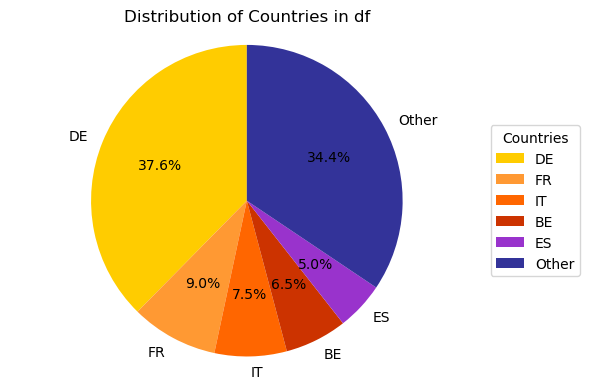

Total number of entries: 10875961


In [11]:
# Counting the entries per country
country_counts = df['Country'].value_counts()

# The 5 most frequent countries and 'Other'
top_5 = country_counts.nlargest(5)
others = country_counts.sum() - top_5.sum()

# Prepare data for the chart
sizes = list(top_5) + [others]
labels = list(top_5.index) + ['Other']

# Colors for the chart
colors = ['#ffcc00', '#ff9933', '#ff6600', '#cc3300', '#9933cc', '#333399']

# Create a pie chart
plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Ensures that pie is drawn as a circle
plt.title('Distribution of Countries in df')

# Add legend
plt.legend(title="Countries", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Output the total number of entries
print(f"Total number of entries: {len(df)}")

# Drop all columns that might not be relevant for a technical description of a car:

ID: Identification number.
Country: Member state.
Mp: Manufacturer pooling.
Mh: Manufacturer name EU standard denomination.
Man: Manufacturer name OEM declaration.
MMS: Manufacturer name MS registry denomination.
Cn: Commercial name.
r: Total new registrations.
Status: P = Provisional data, F = Final data.
year: Reporting year.
identical occurrences: Number of identical occurrences (duplicates + 1).

In [15]:
# List of non-technical columns to drop
non_technical_columns = [
    'ID', 
    'Country',  
    'Mp', 
    'Mh', 
    'Man', 
    'MMS', 
    'Cn', 
    'r', 
    'Status', 
    'year', 
    'Date of registration'
]

# Assuming df is your DataFrame
df = df.drop(columns=non_technical_columns)

# Display the cleaned DataFrame
print(df.head())

         VFN                 Tan    T         Va        Ve      Mk  Ct  Cr  \
2968982  NaN  e4*2007/46*1205*01   AZ       C33S       MT2  SUZUKI  M1  M1   
2968986  NaN  e4*2007/46*1205*02   AZ       C83S        MT  SUZUKI  M1  M1   
2968987  NaN  e4*2007/46*1205*02   AZ       C83S        MT  SUZUKI  M1  M1   
2969039  NaN  e8*2007/46*0317*02   3T  AADFGAX01         *   SKODA  M1  M1   
2969057  NaN  e1*2007/46*1824*03  F2X       YH11  CAW500L0     BMW  M1  M1   

         m (kg)      Mt  ...  z (Wh/km)      IT  Ernedc (g/km)  Erwltp (g/km)  \
2968982  1045.0  1151.0  ...        NaN     NaN            NaN            NaN   
2968986   915.0  1051.0  ...        NaN     NaN            NaN            NaN   
2968987   915.0  1051.0  ...        NaN     NaN            NaN            NaN   
2969039  1560.0     NaN  ...        NaN     NaN            NaN            NaN   
2969057  1490.0  1578.0  ...        NaN  e24 19            1.2            NaN   

         De   Vf  ech  RLFI  Electric range 

In [16]:
df_cleaned_year_columns = df

# Save the filtered DataFrame as a CSV file
df_cleaned_year_columns.to_csv(os.path.join(data_path, 'EU_CleanedYearsColumns_Big.csv'), index=False)

print("Shape of cleaned df:", df_cleaned_year_columns.shape)
print("Filtered DataFrame has been saved as 'EU_CleanedYearsColumns_Big.csv' in the data_path.")

Shape of cleaned df: (10875961, 29)
Filtered DataFrame has been saved as 'EU_CleanedYearsColumns_Big.csv' in the data_path.


# Check for correlation of other target variables
+ if they have high correlation, delete them -> smaller df 

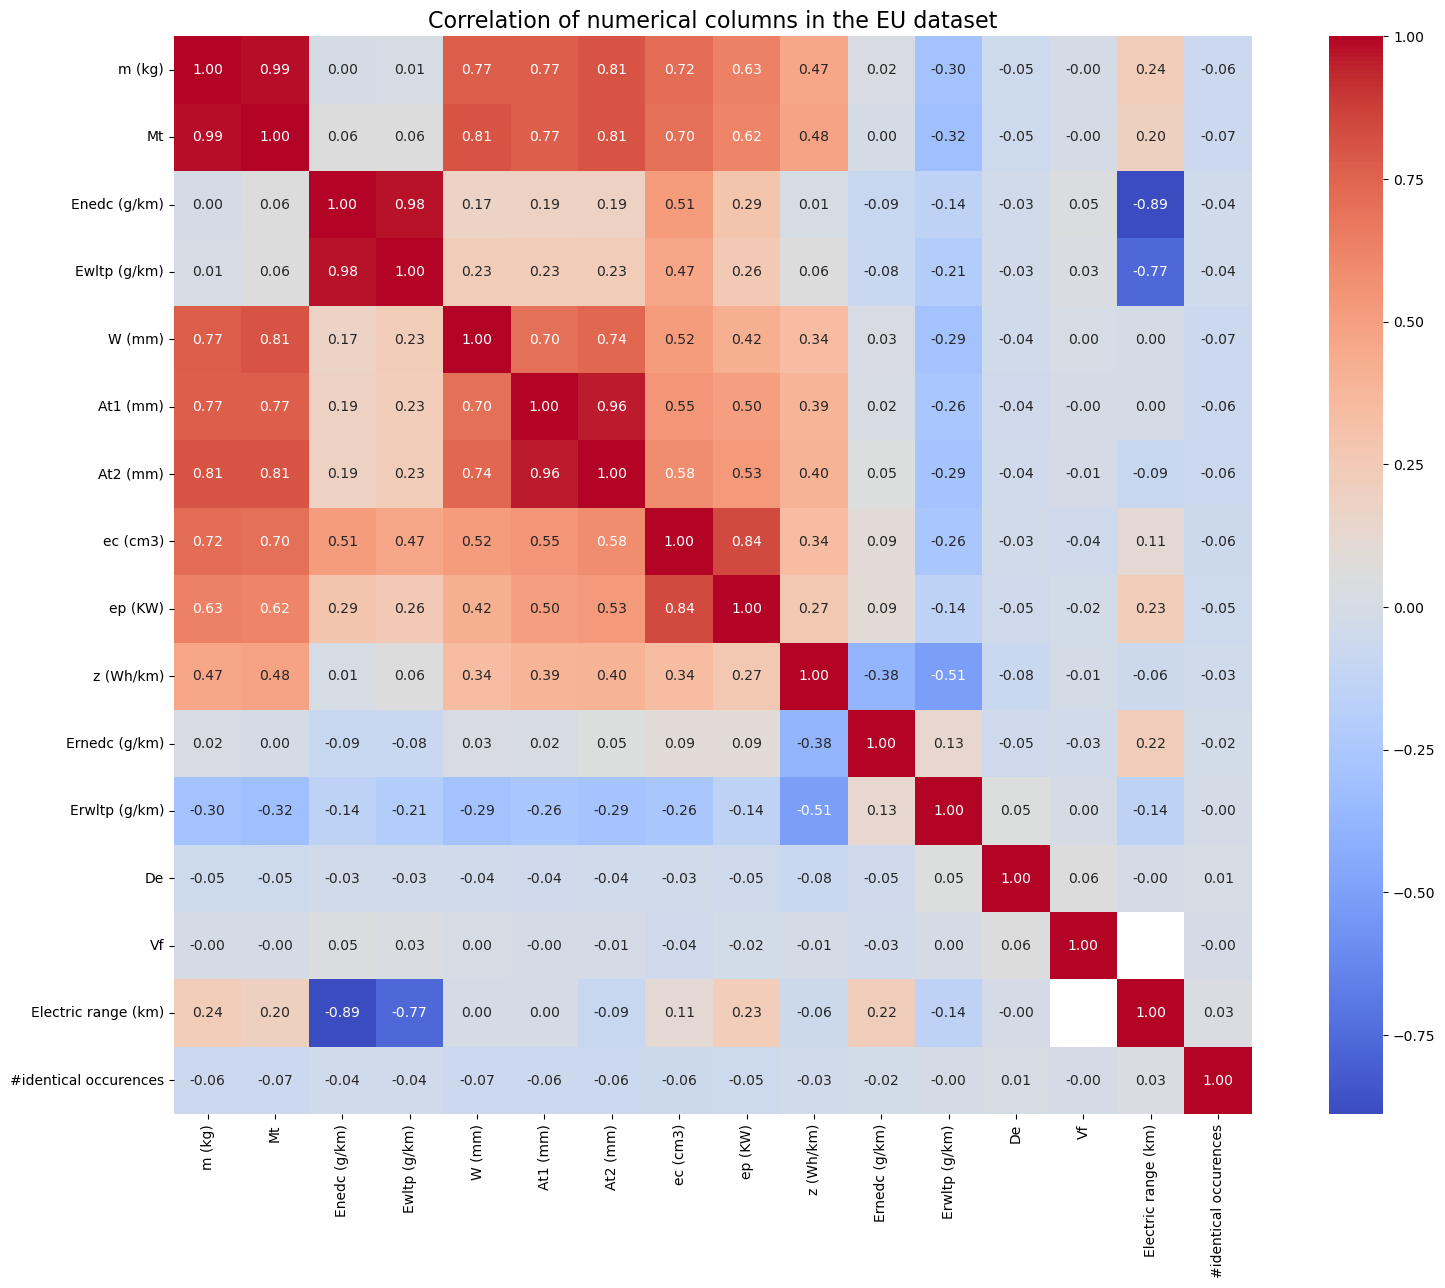

In [17]:
# Calculate correlations of the numerical columns
correlation_matrix = df_cleaned_year_columns.corr()

# Create heatmap
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Add axis labels and title
plt.title('Correlation of numerical columns in the EU dataset', fontsize=16)

# Display plot
plt.show()

# Get rid of Enedec (too much correlation)

In [18]:
# Make the final df
df_final_big = df_cleaned_year_columns.drop(columns=['Enedc (g/km)'])


In [22]:

# Remove rigurousely stuff to be able to work with a small df 
df_new5 = df_final_big.drop(columns=['Ernedc (g/km)'])
df_new6 = df_new5.drop(columns=['Erwltp (g/km)'])



In [23]:

# Remove car identifier 
df_new7 = df_new6.drop(columns=['Ve', 'Va', 'T', 'Tan', 'VFN'])


In [26]:
# Remove all rows which have a nan in interessting correlated columns: 
# 
df_new8 = df_new7.dropna(subset=['W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)'])


In [27]:
# Display the resulting DataFrame
print(df_new8.shape)
# df_new8.head()

(8095869, 21)


,Mk,Ct,Cr,m (kg),Mt,Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,...,ec (cm3),ep (KW),z (Wh/km),IT,De,Vf,ech,RLFI,Electric range (km),#identical occurences
2968982,SUZUKI,M1,M1,1045.0,1151.0,135.0,2450.0,1510.0,1515.0,PETROL,...,1373.0,103.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,86.0
2968986,SUZUKI,M1,M1,915.0,1051.0,115.0,2450.0,1530.0,1530.0,PETROL,...,1242.0,66.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,36.0
2968987,SUZUKI,M1,M1,915.0,1051.0,115.0,2450.0,1520.0,1520.0,PETROL,...,1242.0,66.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,109.0
2969039,SKODA,M1,M1,1560.0,NaN,146.0,2836.0,1578.0,1566.0,DIESEL,...,1968.0,110.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,31.0
2969057,BMW,M1,M1,1490.0,1578.0,149.0,2670.0,1563.0,1562.0,PETROL,...,1499.0,103.0,NaN,e24 19,NaN,0.0,NaN,NaN,NaN,28.0


# Separate into diesel and petrol 


In [61]:
# Separate the big df into diesel and petrol components 
df_tillmann_diesel_big = df_new8[df_new8['Ft'] == 'DIESEL']

df_tillmann_petrol_big = df_new8[df_new8['Ft'] == 'PETROL']

In [62]:
df_tillmann_diesel_big.drop(columns=['Ft'], inplace=True)
print(df_tillmann_diesel_big.shape)
#print(df_tillmann_diesel_big.head())

df_tillmann_petrol_big.drop(columns=['Ft'], inplace=True)
print(df_tillmann_petrol_big.shape)
#print(df_tillmann_petrol_big.head())

(3524772, 20)
(3892371, 20)


In [64]:
# Making small dataframe for training of the models 
df_tillmann_small = df_new8.sample(frac=0.01, random_state=42)  # Set random_state for reproducibility

df_tillmann_smallsmall = df_new8.sample(frac=0.001, random_state=42)  # Set random_state for reproducibility


# Saving different df for working in the ML-Model pipeline 

In [65]:
# Big Dataframe 
df_new8.to_csv(os.path.join(data_path, 'EU_Tillmann_Big.csv'), index=False)

print("Shape of tillmanns big df:", df_new8.shape)
print("Filtered DataFrame has been saved as 'EU_Tillmann_Big.csv' in the data_path.")

# Only Diesel 
df_tillmann_diesel_big.to_csv(os.path.join(data_path, 'EU_Tillmann_Diesel.csv'), index=False)

print("Shape of tillmanns diesel df:", df_tillmann_diesel_big.shape)
print("Filtered DataFrame has been saved as 'EU_Tillmann_Diesel.csv' in the data_path.")

# Only Petrol 
df_tillmann_petrol_big.to_csv(os.path.join(data_path, 'EU_Tillmann_Petrol.csv'), index=False)

print("Shape of tillmanns diesel df:", df_tillmann_diesel_big.shape)
print("Filtered DataFrame has been saved as 'EU_Tillmann_Petrol.csv' in the data_path.")

# Small dataframe for testing 
df_tillmann_small.to_csv(os.path.join(data_path, 'EU_Tillmann_Small.csv'), index=False)

print("Shape of tillmanns small df:", df_tillmann_small.shape)
print("Filtered DataFrame has been saved as 'EU_Tillmann_Small.csv' in the data_path.")

# SmallSmall dataframe for testing 
df_tillmann_smallsmall.to_csv(os.path.join(data_path, 'EU_Tillmann_SmallSmall.csv'), index=False)

print("Shape of tillmanns smallsmall df:", df_tillmann_smallsmall.shape)
print("Filtered DataFrame has been saved as 'EU_Tillmann_SmallSmall.csv' in the data_path.")


Shape of tillmanns big df: (8095869, 21)
Filtered DataFrame has been saved as 'EU_Tillmann_Big.csv' in the data_path.
Shape of tillmanns diesel df: (3524772, 20)
Filtered DataFrame has been saved as 'EU_Tillmann_Diesel.csv' in the data_path.
Shape of tillmanns diesel df: (3524772, 20)
Filtered DataFrame has been saved as 'EU_Tillmann_Petrol.csv' in the data_path.
Shape of tillmanns small df: (80959, 21)
Filtered DataFrame has been saved as 'EU_Tillmann_Small.csv' in the data_path.
Shape of tillmanns smallsmall df: (8096, 21)
Filtered DataFrame has been saved as 'EU_Tillmann_SmallSmall.csv' in the data_path.


# Working with petrol and diesel df because of different consumation // Proof: see below

In [ ]:
# Show that before working with PETROL or DIESEL that in general 
# Filter the DataFrame for 'PETROL' and 'DIESEL' cars
df_petrol_diesel = df_fuel[df_fuel['Ft'].isin(['PETROL', 'DIESEL'])]



In [55]:
# Identify rows to drop where 'Ft' is any of the specified fuel types
rows_to_drop = df_petrol_diesel[df_petrol_diesel['Ft'].isin(['LPG', 'E85', 'PETROL/ELECTRIC', 'HYDROGEN', 'OTHER', 'ELECTRIC', 'BIODIESEL', 'NG-BIOMETHANE', 'DIESEL/ELECTRIC'])].index

# Remove the identified rows from df_petrol_diesel
df_petrol_diesel = df_petrol_diesel.drop(rows_to_drop)


['DIESEL', 'PETROL']
Categories (11, object): ['BIODIESEL', 'DIESEL', 'DIESEL/ELECTRIC', 'E85', ..., 'NG-BIOMETHANE', 'OTHER', 'PETROL', 'PETROL/ELECTRIC']
       Ft  Fuel consumption   Ewltp (g/km)
0  DIESEL                NaN           NaN
1  PETROL                NaN           NaN
2  DIESEL                NaN           NaN
3  DIESEL                NaN           NaN
4  DIESEL                NaN           NaN


In [56]:

# Show all unique values in the 'Ft' column of df_petrol_diesel
unique_fuel_types = df_petrol_diesel['Ft'].unique()

# Display the unique fuel types
print(unique_fuel_types)


['DIESEL', 'PETROL']
Categories (11, object): ['BIODIESEL', 'DIESEL', 'DIESEL/ELECTRIC', 'E85', ..., 'NG-BIOMETHANE', 'OTHER', 'PETROL', 'PETROL/ELECTRIC']


In [ ]:

# Display the first few rows of the updated DataFrame
print(df_petrol_diesel.head())



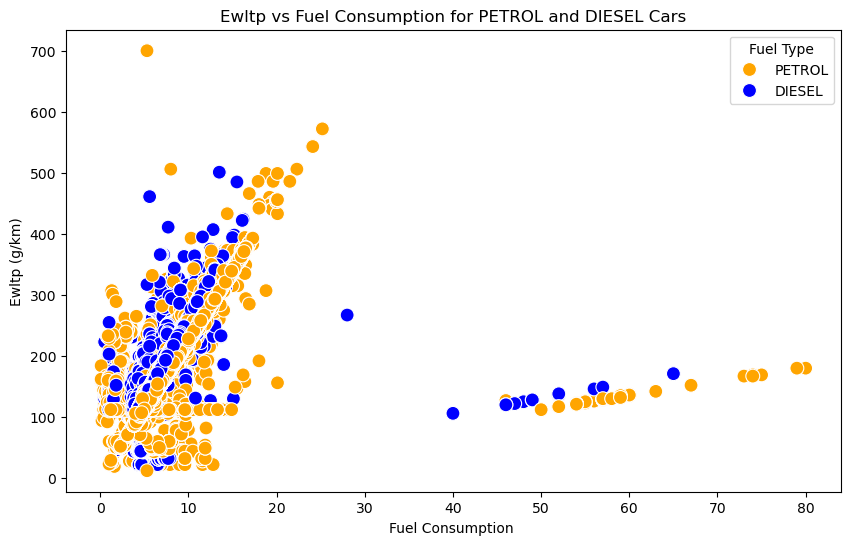

In [58]:

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_petrol_diesel, 
    x='Fuel consumption ', 
    y='Ewltp (g/km)', 
    hue='Ft',  # Use 'Ft' to differentiate colors for 'PETROL' and 'DIESEL'
    hue_order=['PETROL', 'DIESEL'],  # Specify the order of categories
    palette={'PETROL': 'orange', 'DIESEL': 'blue'},  # Define colors
    s=100  # Set the size of the markers
)

# Add labels and a title
plt.xlabel('Fuel Consumption ')
plt.ylabel('Ewltp (g/km)')
plt.title('Ewltp vs Fuel Consumption for PETROL and DIESEL Cars')

# Display the legend and the plot
plt.legend(title='Fuel Type')
plt.show()

# The rest is non relevant 

# Car identifier problem, of multiple appearance cars

# Filter out all rows that have a ? in the Tan, Ve, VFN and delete the whole row

In [14]:
# Define a function that takes a DF and a column name and filteres for all entries with ? and deletes the rows
# Gives back filtered df 

def remove_rows_with_question_mark(df, column_name):
    # Find rows that contain a '?' in the specified column
    rows_with_question_mark = df[df[column_name].str.contains(r'\?', na=False)]
    
    # Drop these rows
    df_filtered_no_questionsmark = df.drop(rows_with_question_mark.index)

    print(f"Rows with '?' in any part of the string in column '{column_name}' have been removed.")
    
    # Return the filtered DataFrame
    return df_filtered_no_questionsmark

In [15]:
def clean_dataframe(df):
    # Remove rows with '?' from the specified columns
    df_cleaned = remove_rows_with_question_mark(df, 'Ve')
    df_cleaned = remove_rows_with_question_mark(df_cleaned, 'Tan')
    df_cleaned = remove_rows_with_question_mark(df_cleaned, 'VFN')
    
    return df_cleaned

# Example usage
# Assuming df is your original DataFrame
df_cleaned_of_questionsmarks = clean_dataframe(df)

Rows with '?' in any part of the string in column 'Ve' have been removed.
Rows with '?' in any part of the string in column 'Tan' have been removed.
Rows with '?' in any part of the string in column 'VFN' have been removed.


In [16]:
# Save the filtered DataFrame as a CSV file
df_cleaned_of_questionsmarks.to_csv(os.path.join(data_path, 'EU_NoQuestionmarks.csv'), index=False)

print("Shape of cleaned df from questionsmarks:", df_cleaned_of_questionsmarks.shape)
print("Filtered DataFrame has been saved as 'EU_NoQuestionmarks.csv' in the data_path.")

Shape of cleaned df from questionsmarks: (10659027, 29)
Filtered DataFrame has been saved as 'EU_NoQuestionmarks.csv' in the data_path.


In [17]:
# Re identify the data frame 
df = df_cleaned_of_questionsmarks

# Searching for repeating car identification numbers in the data to delete possible repatings and therefore minimizing bias if a car appears very often 

In [18]:
def find_top_10_most_frequent(df):
    # Find duplicate values in the 'Ve', 'Tan', and 'VFN' columns
    duplicate_values_Ve = df['Ve'][df['Ve'].duplicated()]
    duplicate_values_Tan = df['Tan'][df['Tan'].duplicated()]
    duplicate_values_VFN = df['VFN'][df['VFN'].duplicated()]

    # Count unique duplicate values for each column
    duplicate_counts_Ve = duplicate_values_Ve.value_counts()
    duplicate_counts_Tan = duplicate_values_Tan.value_counts()
    duplicate_counts_VFN = duplicate_values_VFN.value_counts()

    # Save the most frequent value for each column
    most_frequent_Ve = duplicate_counts_Ve.idxmax() if not duplicate_counts_Ve.empty else None
    most_frequent_Tan = duplicate_counts_Tan.idxmax() if not duplicate_counts_Tan.empty else None
    most_frequent_VFN = duplicate_counts_VFN.idxmax() if not duplicate_counts_VFN.empty else None

    # Get the top 10 most frequently appearing values
    top_10_Ve = duplicate_counts_Ve.head(10)
    top_10_Tan = duplicate_counts_Tan.head(10)
    top_10_VFN = duplicate_counts_VFN.head(10)

    return most_frequent_Ve, most_frequent_Tan, most_frequent_VFN, top_10_Ve, top_10_Tan, top_10_VFN, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN

In [19]:
most_frequent_Ve, most_frequent_Tan, most_frequent_VFN, top_10_Ve, top_10_Tan, top_10_VFN, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN = find_top_10_most_frequent(df)

# Display results
print("Most frequent 'Ve':", most_frequent_Ve)
print("Most frequent 'Tan':", most_frequent_Tan)
print("Most frequent 'VFN':", most_frequent_VFN)

print("\nTop 10 most frequent 'Ve':")
print(top_10_Ve)

print("\nTop 10 most frequent 'Tan':")
print(top_10_Tan)

print("\nTop 10 most frequent 'VFN':")
print(top_10_VFN)

Most frequent 'Ve': IAW50000
Most frequent 'Tan': e1*2001/116*0480*41
Most frequent 'VFN': IP-MQB37WZ_A0_0589-TMB-1

Top 10 most frequent 'Ve':
IAW50000    108013
DAW50000     95284
DAW500L0     84038
IAW500L0     71662
CZAA050A     71281
FZAA150A     43749
IAW500B0     43597
JZAA150A     37842
6AW50000     37212
HZAA150A     29583
Name: Ve, dtype: int64

Top 10 most frequent 'Tan':
e1*2001/116*0480*41    26332
e1*2001/116*0470*23    24697
e1*2007/46*1909*19     24677
e1*2007/46*1885*17     24351
e1*2001/116*0220*53    23844
e1*2007/46*2018*07     23656
e1*2007/46*1909*17     23602
e8*2007/46*0355*14     23202
e13*2007/46*1911*06    22944
e1*2007/46*1797*04     22839
Name: Tan, dtype: int64

Top 10 most frequent 'VFN':
IP-MQB37WZ_A0_0589-TMB-1    26231
IP-2018_1435-WDB-1          24029
IP-MQB48ZZ_A1_0843-WVW-1    23809
IP-MQB37AS_A3_0817-WVW-1    23658
IP-0000529-WBA-1            22401
IP-2018_1437-WDB-1          22182
IP-MQB27SZ_A0_0539-TMB-1    22114
IP-0000501-WBA-1            22055

In [12]:
def calculate_percentage_error_10mostoftenappearing(df, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN):
    # Ve calculations for the 10 most frequent 'Ve'
    top_10_Ve = duplicate_counts_Ve.index[:10]  # Get the 10 most frequent 'Ve' values
    percentage_errors_Ve = []

    for ve_value in top_10_Ve:
        filtered_df_Ve = df[df['Ve'] == ve_value]
        mean_values_Ve = filtered_df_Ve.mean(numeric_only=True)
        numeric_df_Ve = filtered_df_Ve.select_dtypes(include=[np.number])
        rmse_values_Ve = np.sqrt(((numeric_df_Ve - mean_values_Ve) ** 2).mean())
        percentage_error_Ve = (rmse_values_Ve / mean_values_Ve) * 100
        percentage_errors_Ve.append(percentage_error_Ve)
        print(f"\nPercentage error relative to the mean for 'Ve' = {ve_value}: {percentage_error_Ve}")
    
    # Tan calculations for the 10 most frequent 'Tan'
    top_10_Tan = duplicate_counts_Tan.index[:10]  # Get the 10 most frequent 'Tan' values
    percentage_errors_Tan = []

    for tan_value in top_10_Tan:
        filtered_df_Tan = df[df['Tan'] == tan_value]
        mean_values_Tan = filtered_df_Tan.mean(numeric_only=True)
        numeric_df_Tan = filtered_df_Tan.select_dtypes(include=[np.number])
        rmse_values_Tan = np.sqrt(((numeric_df_Tan - mean_values_Tan) ** 2).mean())
        percentage_error_Tan = (rmse_values_Tan / mean_values_Tan) * 100
        percentage_errors_Tan.append(percentage_error_Tan)
        print(f"\nPercentage error relative to the mean for 'Tan' = {tan_value}: {percentage_error_Tan}")
    
    # VFN calculations for the 10 most frequent 'VFN'
    top_10_VFN = duplicate_counts_VFN.index[:10]  # Get the 10 most frequent 'VFN' values
    percentage_errors_VFN = []

    for vfn_value in top_10_VFN:
        filtered_df_VFN = df[df['VFN'] == vfn_value]
        mean_values_VFN = filtered_df_VFN.mean(numeric_only=True)
        numeric_df_VFN = filtered_df_VFN.select_dtypes(include=[np.number])
        rmse_values_VFN = np.sqrt(((numeric_df_VFN - mean_values_VFN) ** 2).mean())
        percentage_error_VFN = (rmse_values_VFN / mean_values_VFN) * 100
        percentage_errors_VFN.append(percentage_error_VFN)
        print(f"\nPercentage error relative to the mean for 'VFN' = {vfn_value}: {percentage_error_VFN}")
    
    return percentage_errors_Ve, percentage_errors_Tan, percentage_errors_VFN


In [ ]:
def calculate_percentage_error(df, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN):
    # Ve calculations using the most frequent 'Ve'
    most_frequent_Ve = duplicate_counts_Ve.idxmax()  # Get the most frequent 'Ve'
    filtered_df_Ve = df[df['Ve'] == most_frequent_Ve]
    mean_values_Ve = filtered_df_Ve.mean(numeric_only=True)
    numeric_df_Ve = filtered_df_Ve.select_dtypes(include=[np.number])
    rmse_values_Ve = np.sqrt(((numeric_df_Ve - mean_values_Ve) ** 2).mean())
    percentage_error_Ve = (rmse_values_Ve / mean_values_Ve) * 100

    print(f"\nPercentage error relative to the mean for 'Ve': {percentage_error_Ve}")
    
    # Tan calculations using the most frequent 'Tan'
    most_frequent_Tan = duplicate_counts_Tan.idxmax()  # Get the most frequent 'Tan'
    filtered_df_Tan = df[df['Tan'] == most_frequent_Tan]
    mean_values_Tan = filtered_df_Tan.mean(numeric_only=True)
    numeric_df_Tan = filtered_df_Tan.select_dtypes(include=[np.number])
    rmse_values_Tan = np.sqrt(((numeric_df_Tan - mean_values_Tan) ** 2).mean())
    percentage_error_Tan = (rmse_values_Tan / mean_values_Tan) * 100

    print(f"\nPercentage error relative to the mean for 'Tan': {percentage_error_Tan}")
    
    # VFN calculations using the most frequent 'VFN'
    most_frequent_VFN = duplicate_counts_VFN.idxmax()  # Get the most frequent 'VFN'
    filtered_df_VFN = df[df['VFN'] == most_frequent_VFN]
    mean_values_VFN = filtered_df_VFN.mean(numeric_only=True)
    numeric_df_VFN = filtered_df_VFN.select_dtypes(include=[np.number])
    rmse_values_VFN = np.sqrt(((numeric_df_VFN - mean_values_VFN) ** 2).mean())
    percentage_error_VFN = (rmse_values_VFN / mean_values_VFN) * 100

    print(f"\nPercentage error relative to the mean for 'VFN': {percentage_error_VFN}")
    
    return percentage_error_Ve, percentage_error_Tan, percentage_error_VFN

In [21]:
percentage_error_Ve, percentage_error_Tan, percentage_error_VFN = calculate_percentage_error_10mostoftenappearing(df, 
                                                                                                                  duplicate_counts_Ve, duplicate_counts_Tan, 
                                                                                                                  duplicate_counts_VFN)


Percentage error relative to the mean for 'Ve' = IAW50000: m (kg)                    11.264828
Mt                        11.142461
Enedc (g/km)              51.344810
Ewltp (g/km)              90.862381
W (mm)                     4.807154
At1 (mm)                   2.131854
At2 (mm)                   2.535769
ec (cm3)                  30.879038
ep (KW)                   45.726414
z (Wh/km)                 11.861824
Ernedc (g/km)             27.217527
Erwltp (g/km)             24.979265
De                       211.073990
Vf                              NaN
Electric range (km)       26.400167
#identical occurences    362.026825
dtype: float32

Percentage error relative to the mean for 'Ve' = DAW50000: m (kg)                    10.969784
Mt                        11.061568
Enedc (g/km)              37.550304
Ewltp (g/km)              38.806324
W (mm)                     5.396844
At1 (mm)                   1.978980
At2 (mm)                   2.259419
ec (cm3)                  28.545544
e

<class 'str'>


# Filtering for Ve / TVV

In [32]:
text = """
We can see that the most appearing VFN has the least variance among the nummerical values. However in the next steps I will proove that there is small
flaw in the VE variable which I use to drastically shorten the data frame and end up with repeating Ves that occure onle 3000 times, but have a 0
percent variance among the nummerical values. 
"""

print(text)


We can see that the most appearing VFN has the least variance among the nummerical values. However in the next steps I will proove that there is small
flaw in the VE variable which I use to drastically shorten the data frame and end up with repeating Ves that occure onle 3000 times, but have a 0
percent variance among the nummerical values. 



In [33]:
# Function to check if 'T' and 'Va' are contained in 'Ve'
def check_tva(row):
    t = str(row['T'])
    va = str(row['Va'])
    ve = str(row['Ve'])
    return t in ve and va in ve

# Apply the function and filter the DataFrame
df_filtered = df[df.apply(check_tva, axis=1)]

# Check the result
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after filtering: {len(df_filtered)}")

# Display a few examples
print(df_filtered[['T', 'Va', 'Ve']].head())


Original number of rows: 10659027
Number of rows after filtering: 271100
         T    Va      Ve
2673316  U  UZA8  UZA8UC
2677175  U  UZ68  UZ68UC
2677276  U  UZ68  UZ68UC
2677371  U  UZA8  UZA8U4
2677377  U  UZA8  UZA8UC


In [34]:
most_frequent_Ve, most_frequent_Tan, most_frequent_VFN, top_10_Ve, top_10_Tan, top_10_VFN, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN = find_top_10_most_frequent(df_filtered)

# Display results
print("Most frequent 'Ve':", most_frequent_Ve)
print("Most frequent 'Tan':", most_frequent_Tan)
print("Most frequent 'VFN':", most_frequent_VFN)

print("\nTop 10 most frequent 'Ve':")
print(top_10_Ve)

print("\nTop 10 most frequent 'Tan':")
print(top_10_Tan)

print("\nTop 10 most frequent 'VFN':")
print(top_10_VFN)

Most frequent 'Ve': UZK5VC0
Most frequent 'Tan': e9*2007/46*3146*06
Most frequent 'VFN': IP-2020_256K2C-YV1-1

Top 10 most frequent 'Ve':
UZK5VC0        7293
XZ15VD0        6105
XZBBVF0        5074
UZA8VD0        4083
XZ72VD0        3768
UZK5VD0        3760
XZBWVF0        3752
LFK2VC0        3593
UZK9VD0        3440
YHZJ-C2B000    3216
Name: Ve, dtype: int64

Top 10 most frequent 'Tan':
e9*2007/46*3146*06    9858
e4*2007/46*1220*04    8041
e9*2007/46*3146*04    7752
e4*2007/46*1220*03    6681
e9*2007/46*3146*07    6371
e4*2007/46*1220*06    6223
e9*2007/46*3146*15    5782
e4*2007/46*1315*08    5619
e9*2007/46*3146*09    5479
e9*2007/46*3146*08    5448
Name: Tan, dtype: int64

Top 10 most frequent 'VFN':
IP-2020_256K2C-YV1-1        6435
IP-2019_536BBF-YV1-1        6377
IP-2019_53615D-YV1-1        6352
IP-2020_246K5C-YV1-1        5733
IP-2019_536BWF-YV1-1        4208
IP-2020_246K5D-YV1-1        4073
IP-2019_246K9D-YV1-1        3734
IP-2019_256K2C-YV1-1        3563
IP-YHZ____ATN83143-W0V-

In [35]:
percentage_error_Ve, percentage_error_Tan, percentage_error_VFN = calculate_percentage_error_10mostoftenappearing(df_filtered, 
                                                                                                                  duplicate_counts_Ve, duplicate_counts_Tan, 
                                                                                                                  duplicate_counts_VFN)


Percentage error relative to the mean for 'Ve' = UZK5VC0: m (kg)                     1.596140
Mt                         1.692331
Enedc (g/km)               1.725707
Ewltp (g/km)               2.925365
W (mm)                     0.201048
At1 (mm)                   2.049440
At2 (mm)                   2.069758
ec (cm3)                   0.000000
ep (KW)                    0.042115
z (Wh/km)                       NaN
Ernedc (g/km)              5.334348
Erwltp (g/km)              2.683666
De                              NaN
Vf                              NaN
Electric range (km)             NaN
#identical occurences    355.394318
dtype: float32

Percentage error relative to the mean for 'Ve' = XZ15VD0: m (kg)                     1.518726
Mt                         1.541713
Enedc (g/km)               1.260276
Ewltp (g/km)               1.451720
W (mm)                     0.818949
At1 (mm)                   1.800020
At2 (mm)                   1.762415
ec (cm3)                   0.103840
ep 

# Group by TVV and calculate average and RMSE for each nummeric column

In [40]:
# Print the columns of your DataFrame
print(df_filtered.columns)
df_filtered.head()

Index(['VFN', 'Tan', 'T', 'Va', 'Ve', 'Mk', 'Ct', 'Cr', 'm (kg)', 'Mt',
       'Enedc (g/km)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ft',
       'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Ernedc (g/km)',
       'Erwltp (g/km)', 'De', 'Vf', 'ech', 'RLFI', 'Electric range (km)',
       '#identical occurences'],
      dtype='object')


,VFN,Tan,T,Va,Ve,Mk,Ct,Cr,m (kg),Mt,...,z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,ech,RLFI,Electric range (km),#identical occurences
2673316,NaN,e4*2007/46*1220,U,UZA8,UZA8UC,VOLVO,M1,M1,1866.0,2051.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2677175,NaN,e4*2007/46*1220,U,UZ68,UZ68UC,VOLVO,M1,M1,1901.0,2141.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2677276,NaN,e4*2007/46*1220,U,UZ68,UZ68UC,VOLVO,M1,M1,1901.0,2042.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2677371,NaN,e4*2007/46*1220,U,UZA8,UZA8U4,VOLVO,M1,M1,1815.0,1940.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2677377,NaN,e4*2007/46*1220,U,UZA8,UZA8UC,VOLVO,M1,M1,1866.0,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# Group of columns I want to average: 
""""
m (kg): Mass in running order (weight of the vehicle).
Mt: WLTP test mass.
Enedc (g/km): Specific CO2 emissions (NEDC test).
Ewltp (g/km): Specific CO2 emissions (WLTP test).
W (mm): Wheelbase (length between the front and rear axles).
At1 (mm): Axle width (steering axle).
At2 (mm): Axle width (other axle).
ep (KW): Engine power (in kilowatts).
ec (cm3): Engine capacity (in cubic centimeters).
Electric range (km): Electric range of the vehicle.
z (Wh/km): Electric energy consumption (energy used per distance).
Ernedc (g/km): Emissions reduction through innovative technologies (NEDC).
Erwltp (g/km): Emissions reduction through innovative technologies (WLTP).
""""

In [41]:
list_columns_avg = 'm (kg)', 'Mt', 'Ewltp', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ep (KW)', 'ec (cm3)', 'Electric range (km)', 'z (Wh/km)', 'Erwltp (g/km)'

In [44]:

def combine_by_Ve_custom(df, list_columns_avg):
    """
    Combine rows in the DataFrame based on the same 'Ve' value,
    calculating the average and RMSE for specified columns
    and the mode for all other columns.

    Parameters:
    df (pd.DataFrame): Input DataFrame with a 'Ve' column.
    list_columns_avg (list): List of column names for which to calculate averages and RMSE.

    Returns:
    pd.DataFrame: A new DataFrame with combined rows, averages, RMSE, and modes.
    """
    
    # Identify columns that are not in list_columns_avg for mode aggregation
    other_columns = df.columns.difference(list_columns_avg + ['Ve'])
    
    # Prepare a dictionary for aggregation
    agg_dict = {
        col: ['mean', lambda x: np.sqrt(((x - x.mean()) ** 2).mean())] for col in list_columns_avg
    }
    
    # Add mode aggregation for other columns
    for col in other_columns:
        agg_dict[col] = lambda x: x.mode()[0]  # Get the most frequent value

    # Group by 'Ve' and aggregate
    grouped_df = df.groupby('Ve').agg(agg_dict).reset_index()

    # Rename columns to include suffixes
    for col in list_columns_avg:
        grouped_df.rename(columns={col: f"{col}_avg"}, inplace=True)
        grouped_df.rename(columns={col: f"{col}_RMSE"}, inplace=True)

    return grouped_df

# Example usage
# Assuming your DataFrame is named df and contains the specified columns
list_columns_avg = [
    'm (kg)', 'Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 
    'At2 (mm)', 'ep (KW)', 'ec (cm3)', 'Electric range (km)', 
    'z (Wh/km)', 'Erwltp (g/km)'
]

result_df = combine_by_Ve_custom(df_filtered, list_columns_avg)

KeyError: 0

In [ ]:
# Save the filtered DataFrame as a CSV file
df_filtered.to_csv(os.path.join(data_path, 'EU_Tv_Filtered.csv'), index=False)

print("Filtered DataFrame has been saved as 'EU_Tv_Filtered.csv' in the data_path.")

In [29]:
# Load the DataFrame from the file path
df_filtered_Tv = pd.read_csv(os.path.join(data_path, 'EU_Tv_Filtered.csv'))

# I am going for VFN, it has the lowest error rate 

In [ ]:
print(type(most_frequent_VFN))


# List of the 10 most frequent VFNs
most_frequent_VFN_10 = [
    'IP-MQB37WZ_A0_0589-TMB-1',
    'IP-2018_1435-WDB-1',
    'IP-MQB48ZZ_A1_0843-WVW-1',
    'IP-MQB37AS_A3_0817-WVW-1',
    'IP-0000529-WBA-1',
    'IP-2018_1437-WDB-1',
    'IP-MQB27SZ_A0_0539-TMB-1',
    'IP-0000501-WBA-1',
    'IP-MLB42AZ_B0_0688-WAU-1',
    'IP-0000714-WBA-1'
]

In [31]:


# Initialize a dictionary to store results
results = {}

# Loop through each most frequent VFN
for vfn in most_frequent_VFN_10:
    # Filter the DataFrame to get rows with the current VFN
    filtered_df = df[df['VFN'] == vfn]

    # Count occurrences of TANs for the current VFN
    tan_counts = filtered_df['Tan'].value_counts().nlargest(5)  # Get top 5 TANs

    # Store the results
    results[vfn] = tan_counts

# Print the results
for vfn, tan_counts in results.items():
    print(f"Top 5 TANs for VFN {vfn}:")
    print(tan_counts)
    print()

Top 5 TANs for VFN IP-MQB37WZ_A0_0589-TMB-1:
e8*2007/46*0355*14    4170
e8*2007/46*0355*10    3459
e8*2007/46*0355*15    3070
e8*2007/46*0355*09    3051
e8*2007/46*0355*06    2595
Name: Tan, dtype: int64

Top 5 TANs for VFN IP-2018_1435-WDB-1:
e1*2007/46*1829*06    1229
e1*2007/46*1829*12    1164
e1*2007/46*1912*19    1096
e1*2007/46*1912*18    1048
e1*2007/46*1912*08     982
Name: Tan, dtype: int64

Top 5 TANs for VFN IP-MQB48ZZ_A1_0843-WVW-1:
e1*2001/116*0307*69    2369
e1*2001/116*0307*74    2283
e1*2001/116*0307*72    2207
e1*2001/116*0307*70    2057
e1*2001/116*0307*75    2044
Name: Tan, dtype: int64

Top 5 TANs for VFN IP-MQB37AS_A3_0817-WVW-1:
e1*2001/116*0450*64    2336
e1*2001/116*0450*70    2320
e1*2001/116*0450*63    2200
e1*2001/116*0450*62    2162
e1*2001/116*0450*67    2051
Name: Tan, dtype: int64

Top 5 TANs for VFN IP-0000529-WBA-1:
e1*2007/46*2018*07    5691
e1*2007/46*2018*06    3120
e1*2007/46*2018*03    2981
e1*2007/46*2018*04    2450
e1*2007/46*2064*07    2192
Name

# Clean all outlier rows of the duplicate Ves 

# This should only concern the outliers of the feature variables, not the target! and we only use some feature variables 

# This need to be addapted better 

In [39]:
def remove_outliers_from_duplicates(df, column_name):
    # Finde die duplizierten Werte in der angegebenen Spalte
    duplicate_values = df[column_name][df[column_name].duplicated()]
    duplicate_counts = duplicate_values.value_counts()

    # Erstelle ein leeres DataFrame für die gefilterten Ergebnisse
    df_filtered = pd.DataFrame()

    # Iteriere über die duplizierten Werte
    for value in duplicate_counts.index:
        # Filtere die Zeilen, die den aktuellen duplizierten Wert enthalten
        duplicate_rows = df[df[column_name] == value]

        # Berechne den IQR für die numerischen Spalten
        numeric_columns = duplicate_rows.select_dtypes(include=[float, int]).columns
        Q1 = duplicate_rows[numeric_columns].quantile(0.25)
        Q3 = duplicate_rows[numeric_columns].quantile(0.75)
        IQR = Q3 - Q1

        # Bestimme die Grenzen für Ausreißer
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Finde die Zeilen, die keine Ausreißer sind
        is_outlier = (duplicate_rows[numeric_columns] < lower_bound) | (duplicate_rows[numeric_columns] > upper_bound)
        non_outlier_rows = duplicate_rows[~is_outlier.any(axis=1)]

        # Füge die nicht ausreißenden Zeilen dem gefilterten DataFrame hinzu
        df_filtered = pd.concat([df_filtered, non_outlier_rows], ignore_index=True)

    print(f"Ausreißer aus den Duplikaten in der Spalte '{column_name}' wurden entfernt.")
    
    # Rückgabe des gefilterten DataFrames
    return df_filtered


In [40]:

# Beispielnutzung
# Angenommen, df ist dein ursprüngliches DataFrame
df_cleaned_outliers = remove_outliers_from_duplicates(df_cleaned_of_questionsmarks, 'Ve')

KeyboardInterrupt: 

In [ ]:
# Save the filtered DataFrame as a CSV file
df_cleaned_outliers.to_csv(os.path.join(data_path, 'EU_Ve_OutliersCleaned.csv'), index=False)
print("Shape of cleaned df from questionsmarks:", df_cleaned_outliers.shape)
print("Filtered DataFrame has been saved as 'EU_NoQuestionmarks.csv' in the data_path.")

In [ ]:
# Now find again the most often appearing values and do again a search for the percentage error of the remaining df_filtered_Tv

In [33]:
most_frequent_Ve, most_frequent_Tan, most_frequent_VFN, top_10_Ve, top_10_Tan, top_10_VFN, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN = find_top_10_most_frequent(df_filtered_Tv)


# Display results
print("Most frequent 'Ve':", most_frequent_Ve)
print("Most frequent 'Tan':", most_frequent_Tan)
print("Most frequent 'VFN':", most_frequent_VFN)

print("\nTop 10 most frequent 'Ve':")
print(top_10_Ve)

print("\nTop 10 most frequent 'Tan':")
print(top_10_Tan)

print("\nTop 10 most frequent 'VFN':")
print(top_10_VFN)

Most frequent 'Ve': UZK5VC0?
Most frequent 'Tan': e9*2007/46*3146*06
Most frequent 'VFN': IP-2020_246K5C-YV1-1

Top 10 most frequent 'Ve':
UZK5VC0?    8019
UZK5VC0     7293
XZ15VD0     6105
XZBBVF0     5074
XZ15VD0?    4861
XZBBVF0?    4839
UZH1VD0?    4443
UZA8VD0     4083
XZBWVF0?    3912
XZ72VD0     3768
Name: Ve, dtype: int64

Top 10 most frequent 'Tan':
e9*2007/46*3146*06    15205
e4*2007/46*1220*04    12281
e4*2007/46*1315*08    12166
e9*2007/46*3146*04    12063
e9*2007/46*3146*15    12005
e4*2007/46*1220*17    10674
e9*2007/46*3146*07    10568
e9*2007/46*3146*09    10105
e4*2007/46*1220*03     9815
e4*2007/46*1220*06     9766
Name: Tan, dtype: int64

Top 10 most frequent 'VFN':
IP-2020_246K5C-YV1-1    11175
IP-2019_536BBF-YV1-1    11171
IP-2019_53615D-YV1-1    10617
IP-2020_256K2C-YV1-1     9891
IP-2019_536BWF-YV1-1     7967
IP-2021_246H1D-YV1-1     7249
IP-2020_246K5D-YV1-1     6159
IP-2019_536L4D-YV1-1     5976
IP-2021_256H5D-YV1-1     5802
IP-2019_246K9D-YV1-1     5623
Name: 

In [31]:
percentage_error_Ve, percentage_error_Tan, percentage_error_VFN = calculate_percentage_error_10mostoftenappearing(df_filtered_Tv, duplicate_counts_Ve, duplicate_counts_Tan, duplicate_counts_VFN)


Percentage error relative to the mean for 'Ve' = UZK5VC0?: ID                        80.024459
r                          0.000000
m (kg)                     1.582903
Mt                         1.786811
Enedc (g/km)               1.905135
Ewltp (g/km)               2.849370
W (mm)                     0.853698
At1 (mm)                   2.191846
At2 (mm)                   2.203917
ec (cm3)                   0.000000
ep (KW)                    4.153804
z (Wh/km)                       NaN
Ernedc (g/km)              3.379381
Erwltp (g/km)              1.942535
De                              NaN
Vf                              NaN
year                       0.062975
Electric range (km)             NaN
#identical occurences    252.007491
dtype: float64

Percentage error relative to the mean for 'Ve' = UZK5VC0: ID                        78.016510
r                          0.000000
m (kg)                     1.596219
Mt                         1.692333
Enedc (g/km)               1.725711
Ew

Ve scheint wohl laut chat die VIN bzw fahrzeug identifikations nummer zu sein 

Now, lass uns mal danach suchen wie groß die varianz der anderen variablen columns bei einheitlichen 
VINs bzw VEs ist 


Wichtig: hier sieht man das nach dem filtern nur noch 56.000 spalten übrig bleiben, was bei den anderen ist
.. ka

# Begin filtering for duplicates in TAN 

# Begin filtering for duplicates VFN 

## Takeaway To-Dos from Group Meeting: 

- Make My own data frame 
- Take only data that contains EWltp values 
- Take only data year = 2016 and younger (2017 , 2018...)
- Look for duplicates in the Type variables called: TVV, VHF, TAN 
- look for varianze among same of these type variables of the other variables   

- if there is one that has minimum varianz -> take that and unify these 
- make new variable called appearance in EU data, or R 

-> that would be my EU_Dataframe 

# Next Possible Working steps 

Filter out all data that has no explanatory variable 

Filter out all data that is later then 2015 oder wann auch immer diese EU gesetzes änderung und der Gas Skandal war 
(siehe Report)

Try to find eindeutige Beschreibungs nummer eines autos 

Try to find overlay with the Adame Data Frame 

Immer noch die Frage wo ist der Entscheidenden Punkt der Correlation ? 

Hier nochmal danach eine Correlation Maxtrix Ausgeben und Nochmal den Data Audit ansehen, was die Columns zu bedeuten haben 

Explore TVV Combination: Investigate whether we should combine the TVV (Type, Variant, Version) into a single variable, and decide on a common approach.

Outlier Handling: Implement or refine outlier detection and removal in the dataset, ensuring it's properly applied across notebooks.

Analyze the 'R' Column: Further explore the "R" column, especially for values after 2020 where all "R" values equal one. Include this for discussion in the next meeting.

